# Questions

1. могу ли я сделать видео визуализацию по картинкой головы. То есть чтобы было видео как сигнал меняется со временем по голове.
2. Есть ли какая-то проверка на линейнную зависимость каналов


MNE continuous data working

# Import libraries


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import mne
mne.set_log_level('error')


import os
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

# Distinguishing dataset



**Dataset:** [EEG data for Mental Attention State Detection](
https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data)

**Article:** [Distinguishing mental attention states of humans via an EEG-based passive BCI using machine learning methods](https://sci-hub.ru/10.1016/j.eswa.2019.05.057)


Маркировка засчет того что известна сложность маршрута между: focused, unfocused,drowsy


## Reading files

In [2]:
def annotate_func(raw_object):
    my_annotations = mne.Annotations(
        onset=[
            0,             # 0 сек → старт "focused"
            10 * 60       # 600 сек → старт "unfocused"
        ],
        duration=[
            10 * 60,                             # "focused" длится 10 минут (600 сек)
            10 * 60                             # "unfocused" длится тоже 10 минут
        ],
        description=[  # метки классов (будут использованы как метки событий)
            'focused',
            'unfocused'
        ]
    )

    # Применяем аннотации к Raw объекту
    raw_object.set_annotations(my_annotations)

    return raw_object

In [3]:
data_path = 'datasets\\Distinguishing\\'

eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

sfreq = 128
voltage_resolution = 0.51e-6

distinguishing_data = {}


for file_index in range(1, 35):  # от 1 до 34 включительно
    file_name = f'eeg_record{file_index}.mat'
    file_path = os.path.join(data_path, file_name)

    if not os.path.exists(file_path):
        print(f"Файл не найден, пропускаю: {file_name}")
        continue

    # Вычисляем участника и день
    participant_id = min((file_index - 1) // 7 + 1, 5)
    participant_key = f'participant_{participant_id}'

    day_id = (file_index - 1) % 7 + 1
    day_key = f'day_{day_id}'

    # Создаём словарь участника, если он ещё не существует
    if participant_key not in distinguishing_data:
        distinguishing_data[participant_key] = {}

    # Загрузка и обработка данных
    mat_data = scipy.io.loadmat(file_path)
    data = mat_data['o'][0][0]['data']
    eeg_data = pd.DataFrame(data).iloc[:, 4:18].to_numpy().T


    scaled_data = eeg_data * voltage_resolution

    info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types=['eeg'] * len(eeg_channels))
    raw = mne.io.RawArray(scaled_data, info)
    raw.set_montage('standard_1020')

    # Обрезаем до 20 мин, если меньше не трогаем
    raw.crop(tmax=20 * 60)

    # Добавляем аннотацию или data labeling
    raw = annotate_func(raw)

    # Добавляем в структуру
    distinguishing_data[participant_key][day_key] = raw

    print(f'Файл {file_name} загружен → {participant_key}|{day_key} ✅ ')

Файл eeg_record1.mat загружен → participant_1|day_1 ✅ 
Файл eeg_record2.mat загружен → participant_1|day_2 ✅ 
Файл eeg_record3.mat загружен → participant_1|day_3 ✅ 
Файл eeg_record4.mat загружен → participant_1|day_4 ✅ 
Файл eeg_record5.mat загружен → participant_1|day_5 ✅ 
Файл eeg_record6.mat загружен → participant_1|day_6 ✅ 
Файл eeg_record7.mat загружен → participant_1|day_7 ✅ 
Файл eeg_record8.mat загружен → participant_2|day_1 ✅ 
Файл eeg_record9.mat загружен → participant_2|day_2 ✅ 
Файл eeg_record10.mat загружен → participant_2|day_3 ✅ 
Файл eeg_record11.mat загружен → participant_2|day_4 ✅ 
Файл eeg_record12.mat загружен → participant_2|day_5 ✅ 
Файл eeg_record13.mat загружен → participant_2|day_6 ✅ 
Файл eeg_record14.mat загружен → participant_2|day_7 ✅ 
Файл eeg_record15.mat загружен → participant_3|day_1 ✅ 
Файл eeg_record16.mat загружен → participant_3|day_2 ✅ 
Файл eeg_record17.mat загружен → participant_3|day_3 ✅ 
Файл eeg_record18.mat загружен → participant_3|day_4 ✅ 
Ф

## Merging files

In [4]:
# raw_objects_to_concatenate = [
#     distinguishing_data[participant_key][day_key].pick_channels(['F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])
#     for participant_key in sorted(distinguishing_data.keys()) if participant_key in ['participant_1','participant_2','participant_3']
#     for day_key in sorted(distinguishing_data[participant_key].keys()) if day_key in ['day_4','day_5','day_6']
# ]


raw_objects_to_concatenate = [
    distinguishing_data[participant_key][day_key].pick_channels(['F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])
    for participant_key in sorted(distinguishing_data.keys())
    for day_key in sorted(distinguishing_data[participant_key].keys())
]


raw_objects_to_concatenate = [raw_objects_to_concatenate[0].copy()] + raw_objects_to_concatenate[1:]
distinguishing_full = mne.concatenate_raws(raw_objects_to_concatenate)

del distinguishing_data, raw_objects_to_concatenate
distinguishing_full

<RawArray | 12 x 5222434 (40800.3 s), ~478.1 MiB, data loaded>

## Preprocessing

c:\Users\sansa\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


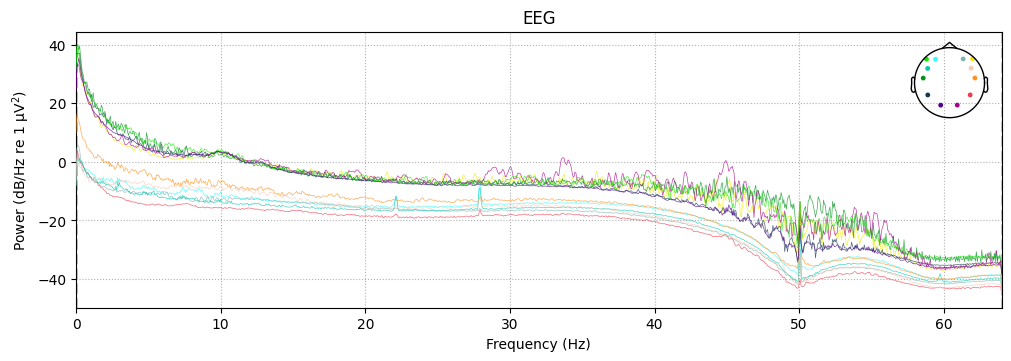

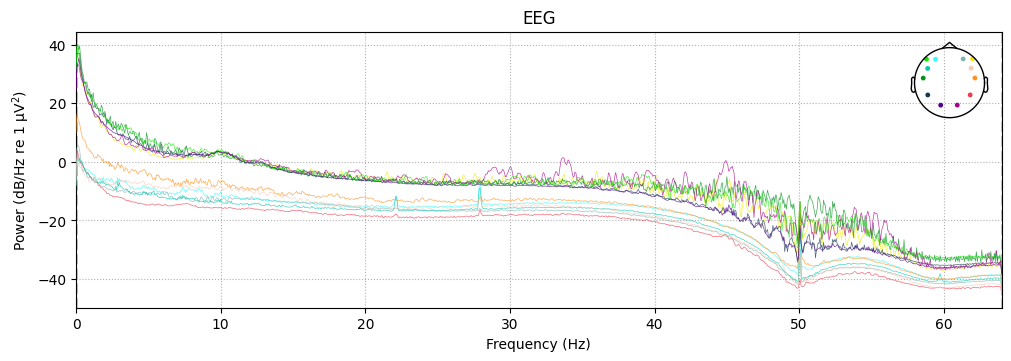

In [5]:
distinguishing_full.compute_psd().plot()

In [6]:
# Artifact removal with ICA

notch_freqs = [50]
ica_l = 1.0
ica_h = 45.0

raw_for_ica = distinguishing_full.copy()
raw_for_ica.notch_filter(freqs=notch_freqs) # Notch filter
raw_for_ica.filter(l_freq=ica_l, h_freq=ica_h) # Bandpass filter specially for ICA

ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
ica.fit(raw_for_ica)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,51 iterations on raw data (5222434 samples)
ICA components,7
Available PCA components,12
Channel types,eeg
ICA components marked for exclusion,—


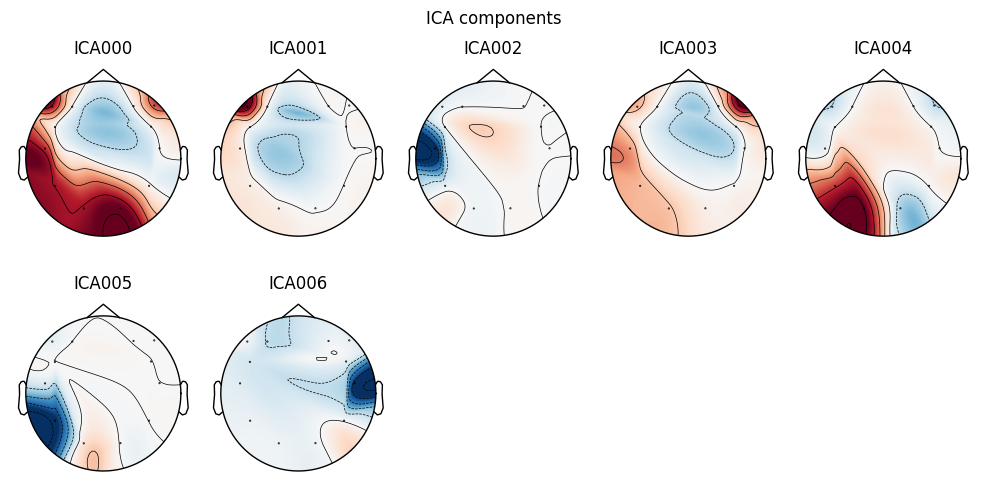

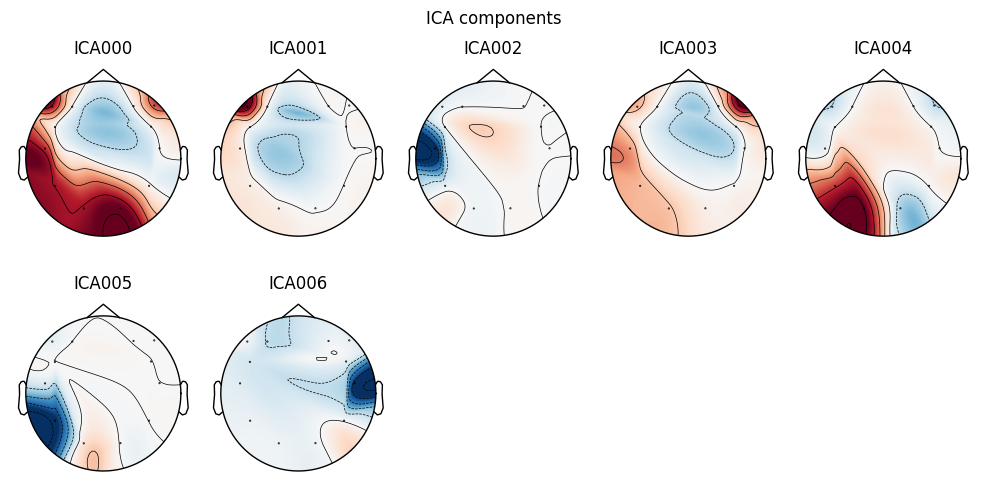

In [7]:
ica.plot_components()

In [8]:
max_ic = 2       # Максимальное число EOG-компонент, которые можно исключить
z_thresh = 2.2   # Начальный Z-порог
z_step = 0.05    # Шаг уменьшения порога

num_excl = 0
final_indices = []

while num_excl < max_ic and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(
        raw_for_ica,  # или epochs
        ch_name=['F3', 'F4', 'F7', 'F8'],
        threshold=z_thresh
    )
    num_excl = len(eog_indices)
    final_indices = eog_indices

    if num_excl < max_ic:
        z_thresh -= z_step
    else:
        break

# Назначаем найденные индексы для удаления
ica.exclude = final_indices


# Применяем
ica.apply(distinguishing_full)

print(f"Final Z-threshold = {z_thresh:.2f}")
print(f"Components to exclude: {ica.exclude}")


Final Z-threshold = 2.05
Components to exclude: [1, 0, 6]


In [9]:
del raw_for_ica, ica

In [10]:
# Filtering
final_l = 0.01
final_h  = 43

distinguishing_full.filter(final_l, final_h)

<RawArray | 12 x 5222434 (40800.3 s), ~478.1 MiB, data loaded>

c:\Users\sansa\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


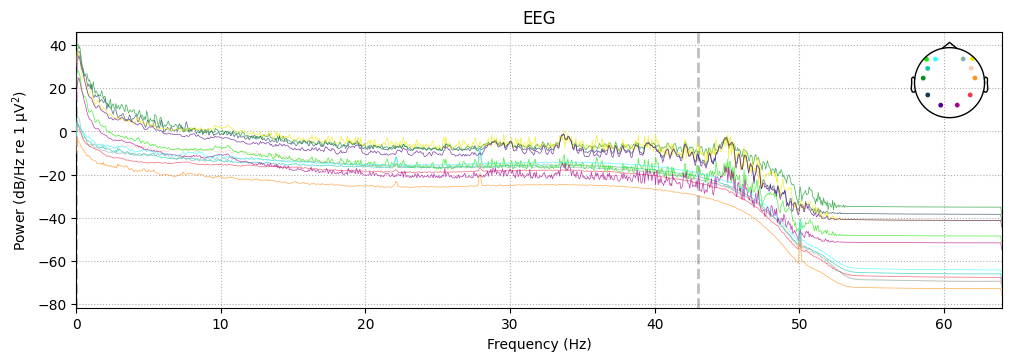

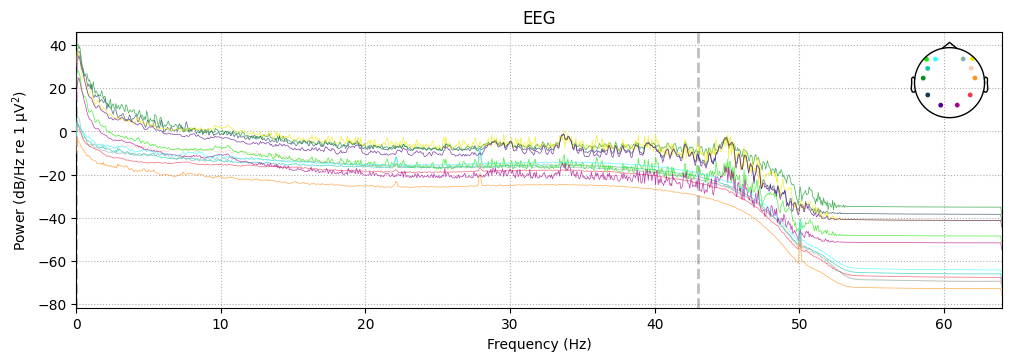

In [11]:
distinguishing_full.compute_psd().plot()

## Segmentation

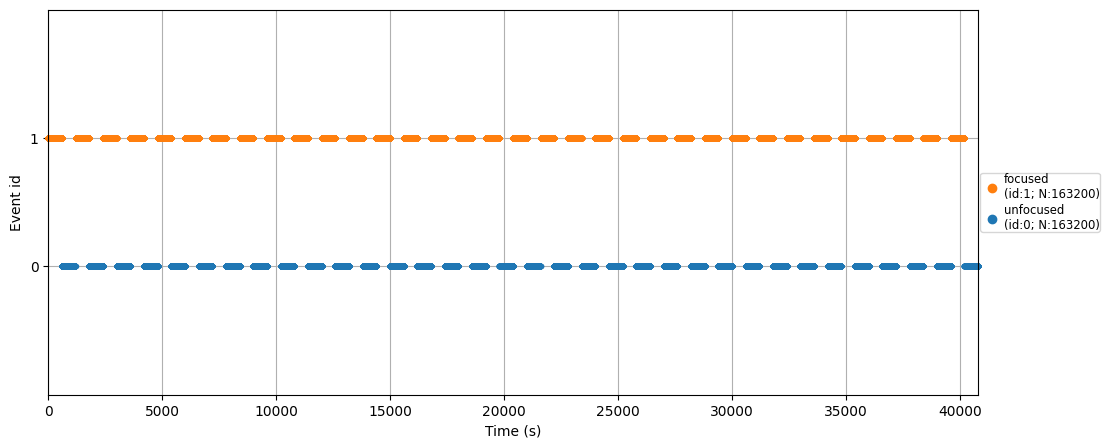

In [12]:
events_maping = {
    'focused':1,
    'unfocused':0
}

events, event_dict = mne.events_from_annotations(distinguishing_full, chunk_duration=0.125, event_id=events_maping)


fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, distinguishing_full.info['sfreq'],
                    event_id=event_dict,
                    axes=ax)
plt.show()

In [13]:
event_dict

{'focused': 1, 'unfocused': 0}

In [14]:
tmin = 0.0       # Начало эпохи относительно события
tmax = 1.0       # Конец эпохи относительно события

distinguishing_epochs = mne.Epochs(
    distinguishing_full,
    events=events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    reject_by_annotation=True # Игнорировать эпохи, попадающие в "bad" аннотации
)

del distinguishing_full


distinguishing_epochs


<Epochs | 326162 events (all good), 0 – 1 s (baseline off), ~3.76 GiB, data loaded,
 'focused': 163200
 'unfocused': 162962>

## Reshaping

In [15]:
# 7. Получаем данные и целевые метки для машинного обучения
X = distinguishing_epochs.get_data(copy=False) # MEG signals: n_epochs, n_meg_channels, n_times
y = distinguishing_epochs.events[:, 2]         # target: auditory left vs visual left (в твоем случае это ID событий)

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"Исходная форма X(n_epochs, n_channels, n_times): {shape}")
print(f"Форма X после преобразования: {X.shape}")
print(f"Форма целевых меток y (n_epochs,): {y.shape}")

Исходная форма X(n_epochs, n_channels, n_times): (326162, 12, 129)
Форма X после преобразования: (326162, 1548)
Форма целевых меток y (n_epochs,): (326162,)


In [16]:
del distinguishing_epochs

## Stratified K-Fold Validation

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

In [18]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(4)


metrics_table

KeyboardInterrupt: 

## GridSearch

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# import numpy as np

# # Параметры для бинарной классификации
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'objective': ['binary:logistic'],  # бинарная классификация
#     'use_label_encoder': [False],     # чтобы избежать предупреждений
#     'eval_metric': ['logloss']        # метрика для бинарной классификации
# }

# # Создаем GridSearchCV объект
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(random_state=42),
#     param_grid=param_grid,
#     scoring='accuracy',  # или другая подходящая метрика для бинарной классификации
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

In [ ]:
# from sklearn.metrics import classification_report

# print("Best parameters found by GridSearchCV:")
# print(grid_search.best_params_)

# best_xgb_model = grid_search.best_estimator_

# y_pred_tuned_xgb = best_xgb_model.predict(X_test)

# print("\nTuned XGBoost Model - Classification Report:")
# print(classification_report(y_test, y_pred_tuned_xgb, target_names=['focused', 'unfocused']))

In [ ]:
# Best parameters found by GridSearchCV:
# {'eval_metric': 'logloss', 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'objective': 'binary:logistic', 'use_label_encoder': False}

# Tuned XGBoost Model - Classification Report:
#               precision    recall  f1-score   support

#      focused       0.86      0.87      0.86      8628
#    unfocused       0.87      0.86      0.86      8640

#     accuracy                           0.86     17268
#    macro avg       0.86      0.86      0.86     17268
# weighted avg       0.86      0.86      0.86     17268

# SAM 40 dataset

**Dataset:** [SAM 40: Dataset](
https://figshare.com/articles/dataset/SAM_40_Dataset_of_40_Subject_EEG_Recordings_to_Monitor_the_Induced-Stress_while_performing_Stroop_Color-Word_Test_Arithmetic_Task_and_Mirror_Image_Recognition_Task/14562090?file=27956376)

**Article:** [SAM 40: Dataset of 40 subject EEG recordings to monitor the induced-stress while performing Stroop color-word test, arithmetic task, and mirror image recognition task](https://www.sciencedirect.com/science/article/pii/S2352340921010465?ref=pdf_download&fr=RR-2&rr=96adf844ce23e918)


Маркировка засчет того что известна сложность маршрута между: focused, unfocused,drowsy

## Reading files

In [ ]:
data_path = 'datasets//SAM 40 dataset//raw_data//'

eeg_channels = [
    'CZ', 'FZ', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5',
    'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1',
    'PZ', 'OZ', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
    'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
]

task_to_class = {
    'relax': 'unfocused',
    'stroop': 'focused',
    'arithmetic': 'focused',
    'mirror': 'focused'
}

sfreq = 128
voltage_resolution = 0.51e-6

sam40 = {}



for task_prefix in ['Relax', 'Stroop', 'Arithmetic', 'Mirror_image']:

    for sub_index in range(1, 41): # 1-40

        for trial_index in range(1,4): # 1-3

            file_name = f'{task_prefix}_sub_{sub_index}_trial{trial_index}.mat'
            file_path = os.path.join(data_path, file_name)

            if not os.path.exists(file_path):
                print(f"Файл не найден, пропускаю: {file_name}")
                continue

            # --- Уникальные ключи ---
            task_key = task_prefix.lower() if task_prefix != 'Mirror_image' else 'mirror'
            subject_key = f'subject_{sub_index}'
            trial_key = f'trial_{trial_index}'


            # Загрузка и обработка данных
            mat_data = scipy.io.loadmat(file_path)

            scaled_data = mat_data['Data'] * voltage_resolution

            info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types=['eeg'] * len(eeg_channels))
            raw = mne.io.RawArray(scaled_data, info)
            raw.set_montage('standard_1020', match_case=False)




            annots = mne.Annotations(
                onset=[0],
                duration=[raw.times[-1]],
                description=[task_to_class[task_key]]
            )
            raw.set_annotations(annots)


            # Добавляем в структуру
            if task_key not in sam40:
                sam40[task_key] = {}
            if subject_key not in sam40[task_key]:
                sam40[task_key][subject_key] = {}

            sam40[task_key][subject_key][trial_key] = raw

            # print(f'✅ Загружен: {file_name} → {task_key} | {subject_key} | {trial_key}')

print(f'✅ Загружен')

✅ Загружен


In [ ]:
import pandas as pd

file_path = 'datasets//SAM 40 dataset//scales.xls'

scales = pd.read_excel(file_path, header=[0, 1])
scales.columns = [' '.join(map(str, col)).strip() for col in scales.columns.values]
scales.columns.values[0] = 'Subject No'
scales.head()

,Subject No,Trial_1 Maths,Trial_1 Symmetry,Trial_1 Stroop,Trial_2 Maths,Trial_2 Symmetry,Trial_2 Stroop,Trial_3 Maths,Trial_3 Symmetry,Trial_3 Stroop
0,1,6,3,3,7,5,2,4,7,4
1,2,3,4,5,3,4,4,7,5,3
2,3,5,3,4,3,5,5,8,7,5
3,4,5,3,4,3,5,2,7,5,5
4,5,6,6,6,5,3,2,5,7,3


In [ ]:
# scales[scales.drop(columns='Subject No').gt(4).all(axis=1)]

## Merging files

In [ ]:
raw_objects_to_concatenate = [
    sam40[task_key][subject_key][trial_key].pick_channels(['F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8'])
    for task_key in sorted(sam40.keys()) if task_key in ['relax', 'stroop', 'arithmetic', 'mirror']
    for subject_key in sorted(sam40[task_key].keys())
    for trial_key in sorted(sam40[task_key][subject_key].keys())
]


raw_objects_to_concatenate = [raw_objects_to_concatenate[0].copy()] + raw_objects_to_concatenate[1:]
sam40_full = mne.concatenate_raws(raw_objects_to_concatenate)

del raw_objects_to_concatenate, sam40
sam40_full

<RawArray | 12 x 1536000 (12000.0 s), ~140.7 MiB, data loaded>

## Preprocessing

c:\Users\sansa\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


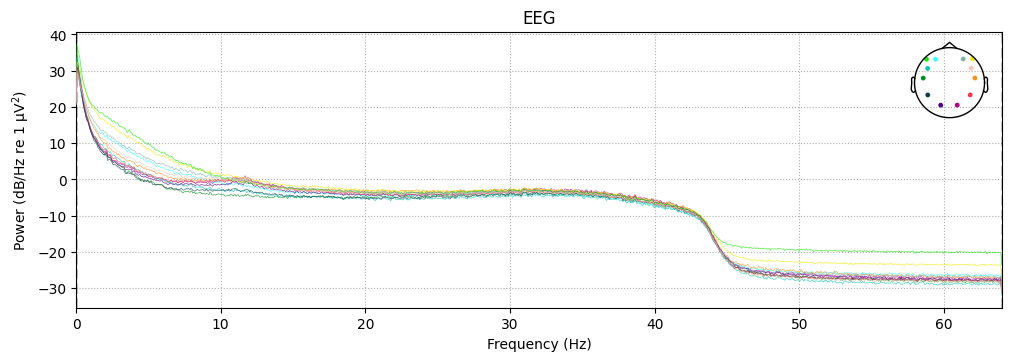

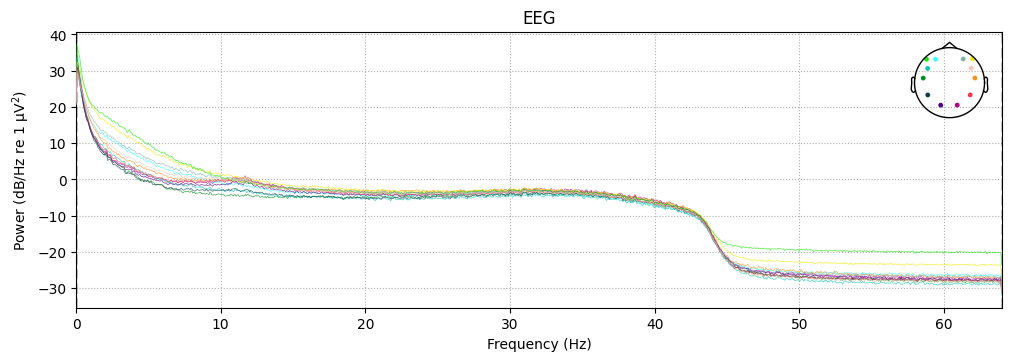

In [ ]:
sam40_full.compute_psd().plot()

In [ ]:
# Artifact removal with ICA

notch_freqs = [50]
ica_l = 1.0
ica_h = 45.0

raw_for_ica = sam40_full.copy()
raw_for_ica.notch_filter(freqs=notch_freqs) # Notch filter
raw_for_ica.filter(l_freq=ica_l, h_freq=ica_h) # Bandpass filter specially for ICA

ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
ica.fit(raw_for_ica)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (1536000 samples)
ICA components,10
Available PCA components,12
Channel types,eeg
ICA components marked for exclusion,—


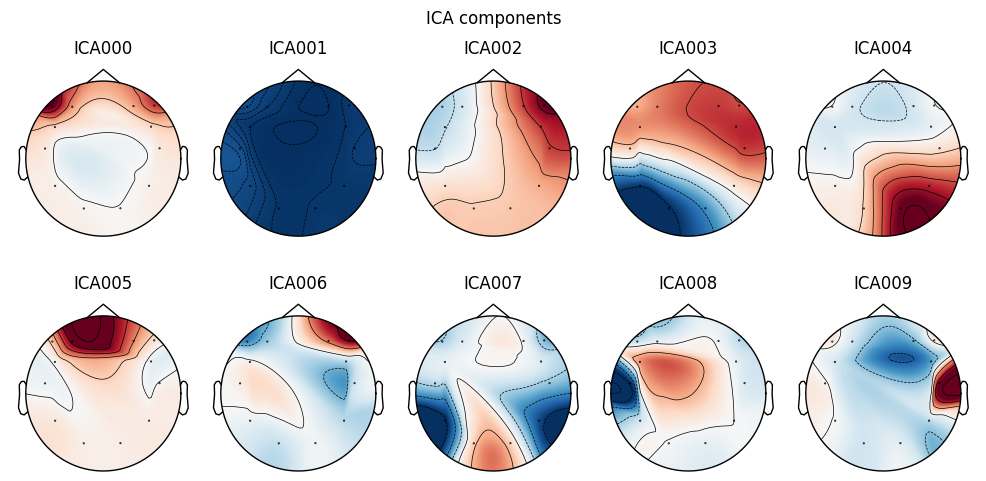

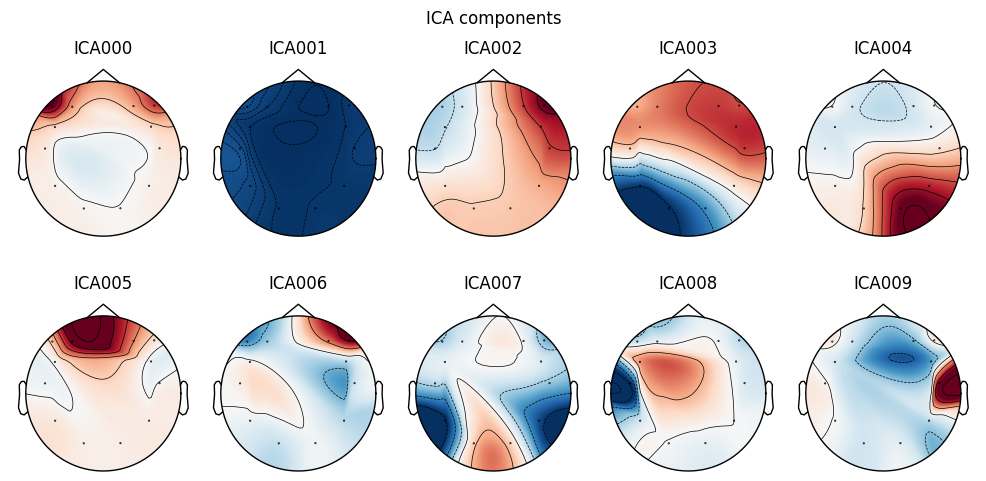

In [ ]:
ica.plot_components()

In [ ]:
max_ic = 2       # Максимальное число EOG-компонент, которые можно исключить
z_thresh = 2.2   # Начальный Z-порог
z_step = 0.05    # Шаг уменьшения порога

num_excl = 0
final_indices = []

while num_excl < max_ic and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(
        raw_for_ica,  # или epochs
        ch_name=['F3', 'F4', 'F7', 'F8'],
        threshold=z_thresh
    )
    num_excl = len(eog_indices)
    final_indices = eog_indices

    if num_excl < max_ic:
        z_thresh -= z_step
    else:
        break

# Назначаем найденные индексы для удаления
ica.exclude = final_indices


# Применяем
ica.apply(sam40_full)

print(f"Final Z-threshold = {z_thresh:.2f}")
print(f"Components to exclude: {ica.exclude}")


Final Z-threshold = 2.05
Components to exclude: [0, 2]


In [ ]:
del raw_for_ica, ica

In [ ]:
# Filtering
final_l = 0.01
final_h  = 43

sam40_full.filter(final_l, final_h)

<RawArray | 12 x 1536000 (12000.0 s), ~140.7 MiB, data loaded>

c:\Users\sansa\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


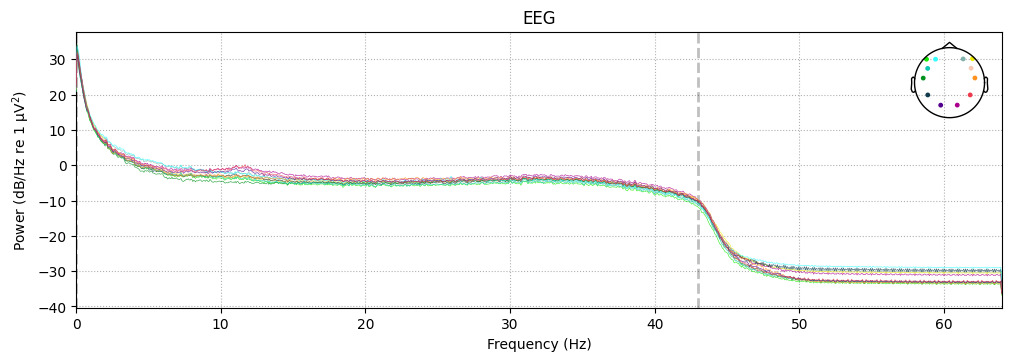

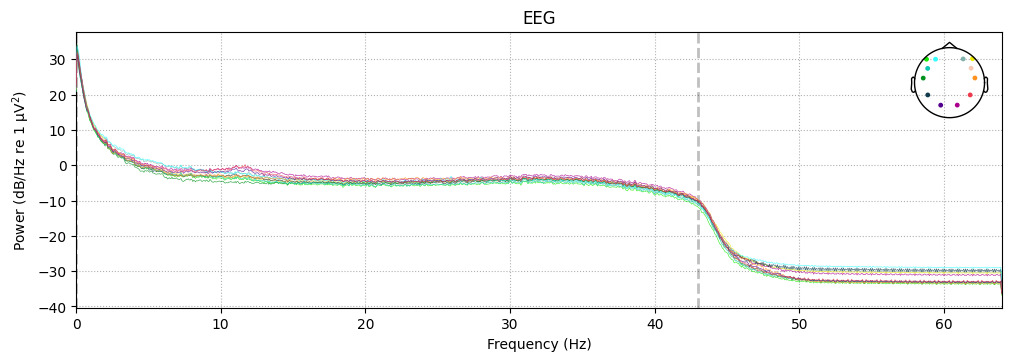

In [ ]:
sam40_full.compute_psd().plot()

## Segmentation

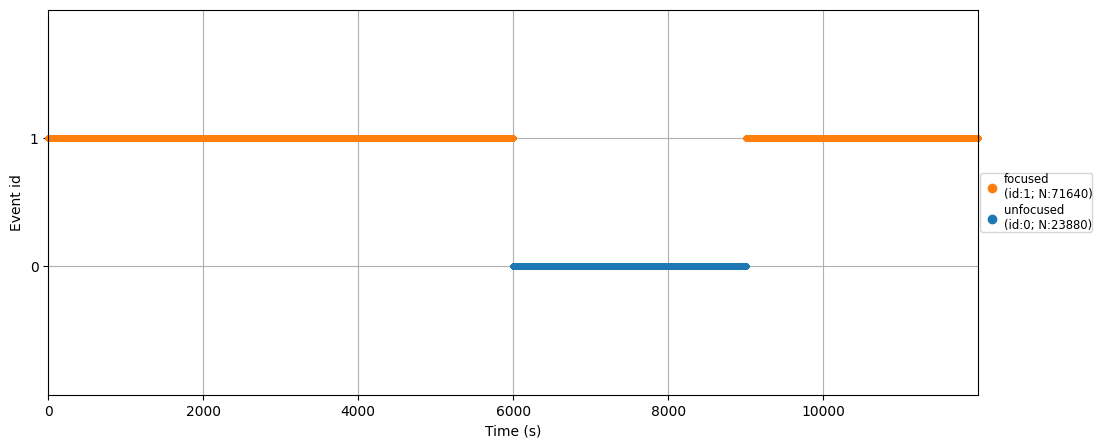

In [ ]:
events_maping = {
    'focused':1,
    'unfocused':0
}

events, event_dict = mne.events_from_annotations(sam40_full, chunk_duration=0.125, event_id=events_maping)


fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, sam40_full.info['sfreq'],
                    event_id=event_dict,
                    axes=ax)
plt.show()

In [ ]:
tmin = 0.0       # Начало эпохи относительно события
tmax = 1.0       # Конец эпохи относительно события

sam40_epochs = mne.Epochs(
    sam40_full,
    events=events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    reject_by_annotation=True # Игнорировать эпохи, попадающие в "bad" аннотации
)

del sam40_full

sam40_epochs


<Epochs | 92160 events (all good), 0 – 1 s (baseline off), ~1.06 GiB, data loaded,
 'focused': 69120
 'unfocused': 23040>

## Reshaping

In [ ]:
X = sam40_epochs.get_data(copy=False) 
y = sam40_epochs.events[:, 2]         

shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"Исходная форма X(n_epochs, n_channels, n_times): {shape}")
print(f"Форма X после преобразования: {X.shape}")
print(f"Форма целевых меток y (n_epochs,): {y.shape}")

Исходная форма X(n_epochs, n_channels, n_times): (92160, 12, 129)
Форма X после преобразования: (92160, 1548)
Форма целевых меток y (n_epochs,): (92160,)


In [ ]:
del sam40_epochs

## Stratified K-Fold Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(4)


metrics_table

,accuracy,precision,recall,f1
0,0.8306,0.8289,0.9755,0.8963
1,0.8254,0.8245,0.9748,0.8933
2,0.8270,0.8248,0.9769,0.8944
3,0.8236,0.8224,0.9755,0.8924
4,0.8283,0.8267,0.9757,0.8950
mean,0.8270,0.8255,0.9757,0.8943
